DATA LOADING AND FIRST CLEANING 

In [ ]:
import pandas as pd
import glob
import nfl_data_py as nfl
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

df_rank = pd.read_csv('/Users/alexanderarens/Desktop/data_science_project/data/FantasyPros_Overall_ADP_Rankings.csv', encoding='ISO-8859-1',delimiter=';')  
df_weekly = nfl.import_weekly_data(years=range(2015,2024)) #player data
df_schedule = nfl.import_schedules(years=range(2015,2024)) #game data
df_weekly = df_weekly.rename(columns={
    'player_display_name': 'name',
    'recent_team': 'team',
    'opponent_team': 'opponent'
})

#clean data
df_weekly = df_weekly[df_weekly['season_type'] == 'REG'] #only regualer season games
df_schedule = df_schedule[df_schedule['game_type'] == 'REG']
relevant_columns = ['season','week','home_team','away_team','home_score','away_score','location',
                           'spread_line','roof','surface','home_coach','away_coach','stadium','game_id']
df_schedule = df_schedule[relevant_columns]

#prepare df_weekly
df_weekly['season'] = df_weekly['season'].astype('int64')
df_weekly['week'] = df_weekly['week'].astype('int64')
df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['team']+'_'+df_weekly['opponent']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent']+'_'+df_weekly['team']

#relevant columms
rel_columns = ['player_display_name', 'player_id', 'position', 'season', 'week', 'team', 'opponent', 'fantasy_points']

df_rank

Downcasting floats.


,rank,name,pos,season
0,1,Adrian Peterson,RB1,2015
1,2,LeâVeon Bell,RB2,2015
2,3,Eddie Lacy,RB3,2015
3,4,Jamaal Charles,RB4,2015
4,5,Marshawn Lynch,RB5,2015
...,...,...,...,...
3298,340,Mo Alie-Cox,TE42,2024
3299,341,James White,RB96,2024
3300,343,A.T. Perry,WR113,2024
3301,344,Jason Witten,TE43,2024


In [ ]:
df_schedule

NameError: name 'nfl_schedule' is not defined

In [20]:
#merge df_rank with df_weekly
df_merged = df_weekly.merge(
    df_rank,
    on=['name','season'],
    how='left')
df_merged.head()
#prepare df
df_merged = pd.melt(
    df_merged,
    id_vars=['player_id','name', 'position', 'season', 'week','team', 'opponent', 'fantasy_points','pos','rank'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id')
#merge df_merged with df_schedules
df_merged = pd.merge(df_merged, 
                     df_schedule[relevant_columns], 
                     on= 'game_id',
                     how='inner')

#Create df for home teams
home_df = df_schedule[['game_id','season','week','home_team','home_score','away_team','away_score']].rename(
    columns={'home_team': 'team', 'home_score': 'points_scored', 'away_team': 'opponent', 'away_score': 'points_allowed'}
).assign(location='home')

#Create df for away teams
away_df = df_schedule[['game_id', 'season', 'week', 'away_team', 'away_score', 'home_team', 'home_score']].rename(
    columns={'away_team': 'team', 'away_score': 'points_scored', 'home_team': 'opponent', 'home_score': 'points_allowed'}
).assign(location='away')

#add the two df above together to have one row per team and game (instead of only one row per game)
df_combined = pd.concat([home_df, away_df], ignore_index=True)

# Rolling average for points scored (offense)
df_combined = df_combined.sort_values(by=['team', 'season', 'week'])
df_combined['rolling_avg_points_scored'] = (
    df_combined.groupby('team')['points_scored']
    .shift(1)
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(drop=True))

# Rolling average for points allowed (defense)
df_combined['rolling_avg_points_allowed'] = (
    df_combined.groupby('team')['points_allowed']
    .shift(1)
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(drop=True))

# Offense rank: Higher points scored -> Better rank
df_combined['offense_rank'] = (
    df_combined.groupby(['season', 'week'])['rolling_avg_points_scored']
    .rank(ascending=False, method='min')
)

# Defense rank: Lower points allowed -> Better rank
df_combined['defense_rank'] = (
    df_combined.groupby(['season', 'week'])['rolling_avg_points_allowed']
    .rank(ascending=True, method='min')
)
df_merged = df_merged.rename(columns={
    'season_x': 'season',
    'week_x': 'week'})
df_merged = df_merged.drop(['season_y','week_y'], axis=1)

df_merged.head()



,player_id,name,position,season,week,team,opponent,fantasy_points,pos,rank,...,away_team,home_score,away_score,location,spread_line,roof,surface,home_coach,away_coach,stadium
0,00-0007091,Matt Hasselbeck,QB,2015,5,IND,HOU,16.219999,QB49,388.0,...,IND,20.0,27.0,Home,4.5,closed,fieldturf,Bill O'Brien,Chuck Pagano,NRG Stadium
1,00-0022044,Andre Johnson,WR,2015,5,IND,HOU,19.700001,WR15,41.0,...,IND,20.0,27.0,Home,4.5,closed,fieldturf,Bill O'Brien,Chuck Pagano,NRG Stadium
2,00-0023500,Frank Gore,RB,2015,5,IND,HOU,15.800000,RB14,31.0,...,IND,20.0,27.0,Home,4.5,closed,fieldturf,Bill O'Brien,Chuck Pagano,NRG Stadium
3,00-0029608,T.Y. Hilton,WR,2015,5,IND,HOU,8.800000,WR9,22.0,...,IND,20.0,27.0,Home,4.5,closed,fieldturf,Bill O'Brien,Chuck Pagano,NRG Stadium
4,00-0029689,Dwayne Allen,TE,2015,5,IND,HOU,2.100000,TE13,122.0,...,IND,20.0,27.0,Home,4.5,closed,fieldturf,Bill O'Brien,Chuck Pagano,NRG Stadium


In [21]:
##merge with the rest
df_merged = pd.merge(
    df_merged,
    df_combined[['season','week','team','points_allowed', 'points_scored', 'rolling_avg_points_scored', 'rolling_avg_points_allowed', 'offense_rank', 'defense_rank']],
    on=['season', 'week', 'team'],
    how='left')



# Create the dummy variable for home games
df_merged['is_home_game'] = (df_merged['home_team'] == df_merged['team']).astype(int)
# create column 'coach'
df_merged['coach'] = np.where(df_merged['is_home_game'], df_merged['home_coach'], df_merged['away_coach'])

#drop missing values = players that were not in the adp df
df_merged = df_merged.dropna(subset=['rank'])

##Rank players for each team and position based on their adp

# Sort the players by their draft rank (lower rank is better)
df_merged['rank'] = pd.to_numeric(df_merged['rank'], errors='coerce')  # Ensure rank is numeric
# Create new column that ranks players within each team and position for every game
df_merged['ranked_position'] = (
    df_merged.groupby(['team', 'position','game_id'])['rank']  # Group by team and position
    .rank(method='min', ascending=True)  # Rank with smallest value having rank 1
    .astype(int)  # Convert the rank to an integer
)
#Formatted column with the position and rank (e.g., 'WR1', 'RB2', etc.)
df_merged['role'] = df_merged['position'] + df_merged['ranked_position'].astype(str)

#rolling average of past fantasy points for each role
df_merged = df_merged.sort_values(by=['team','role','season','week'])
df_merged['avg_fantasy_points'] = (
    df_merged.groupby(['team','role'])['fantasy_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())  # Shift and calculate rolling mean
)
df_merged = df_merged.dropna() #drop the first row for every position in df, because of missing value for avg_fantasy_points
df_merged

/var/folders/f8/sj2vh6pn2550v8b3lybk3zbw0000gn/T/ipykernel_38292/2013616603.py:35: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())  # Shift and calculate rolling mean


,player_id,name,position,season,week,team,opponent,fantasy_points,pos,rank,...,points_scored,rolling_avg_points_scored,rolling_avg_points_allowed,offense_rank,defense_rank,is_home_game,coach,ranked_position,role,avg_fantasy_points
607,00-0021429,Carson Palmer,QB,2015,2,ARI,CHI,21.200001,QB19,142.0,...,48.0,29.6,29.8,9.0,30.0,0,Bruce Arians,1,QB1,25.680000
881,00-0021429,Carson Palmer,QB,2015,3,ARI,SF,18.540001,QB19,142.0,...,47.0,16.8,24.0,28.0,15.0,1,Bruce Arians,1,QB1,23.440001
628,00-0021429,Carson Palmer,QB,2015,5,ARI,DET,18.340000,QB19,142.0,...,42.0,22.0,17.6,16.0,2.0,0,Bruce Arians,1,QB1,21.806667
652,00-0021429,Carson Palmer,QB,2015,6,ARI,PIT,16.740000,QB19,142.0,...,13.0,28.2,23.2,11.0,19.0,0,Bruce Arians,1,QB1,20.940001
414,00-0021429,Carson Palmer,QB,2015,7,ARI,BAL,19.200001,QB19,142.0,...,26.0,28.6,14.6,6.0,2.0,1,Bruce Arians,1,QB1,20.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,00-0027691,Andre Roberts,WR,2015,12,WAS,NYG,0.000000,WR118,393.0,...,20.0,31.6,28.0,6.0,28.0,1,Jay Gruden,4,WR4,2.920000
3355,00-0030187,Rashad Ross,WR,2015,14,WAS,CHI,2.700000,WR113,369.0,...,24.0,25.4,19.4,15.0,7.0,0,Jay Gruden,4,WR4,2.200000
5312,00-0031941,Jamison Crowder,WR,2016,1,WAS,PIT,5.800000,WR79,257.0,...,16.0,22.8,25.6,17.0,15.0,1,Jay Gruden,4,WR4,2.380000
4980,00-0031941,Jamison Crowder,WR,2016,2,WAS,DAL,9.900000,WR79,257.0,...,23.0,18.4,18.8,21.0,5.0,1,Jay Gruden,4,WR4,3.420000


In [22]:
#final seleciton of features
df_pred = df_merged[['season','week','role','team','position','ranked_position','opponent','spread_line','roof', 'is_home_game','offense_rank','defense_rank','points_scored','points_allowed','rolling_avg_points_allowed','rolling_avg_points_scored','avg_fantasy_points','fantasy_points']]
# coach is currently excluded 

df_pred
df_pred.sort_values(by=['team','role','season','week'])
df_pred

,season,week,role,team,position,ranked_position,opponent,spread_line,roof,is_home_game,offense_rank,defense_rank,points_scored,points_allowed,rolling_avg_points_allowed,rolling_avg_points_scored,avg_fantasy_points,fantasy_points
607,2015,2,QB1,ARI,QB,1,CHI,-2.0,outdoors,0,9.0,30.0,48.0,23.0,29.8,29.6,25.680000,21.200001
881,2015,3,QB1,ARI,QB,1,SF,7.0,closed,1,28.0,15.0,47.0,7.0,24.0,16.8,23.440001,18.540001
628,2015,5,QB1,ARI,QB,1,DET,-4.5,dome,0,16.0,2.0,42.0,17.0,17.6,22.0,21.806667,18.340000
652,2015,6,QB1,ARI,QB,1,PIT,-5.5,outdoors,0,11.0,19.0,13.0,25.0,23.2,28.2,20.940001,16.740000
414,2015,7,QB1,ARI,QB,1,BAL,10.0,closed,1,6.0,2.0,26.0,18.0,14.6,28.6,20.100000,19.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2015,12,WR4,WAS,WR,4,NYG,-1.0,outdoors,1,6.0,28.0,20.0,14.0,28.0,31.6,2.920000,0.000000
3355,2015,14,WR4,WAS,WR,4,CHI,4.0,outdoors,0,15.0,7.0,24.0,21.0,19.4,25.4,2.200000,2.700000
5312,2016,1,WR4,WAS,WR,4,PIT,-2.5,outdoors,1,17.0,15.0,16.0,38.0,25.6,22.8,2.380000,5.800000
4980,2016,2,WR4,WAS,WR,4,DAL,3.5,outdoors,1,21.0,5.0,23.0,27.0,18.8,18.4,3.420000,9.900000


                              season      week  ranked_position  spread_line  \
season                      1.000000  0.041123        -0.041474    -0.040827   
week                        0.041123  1.000000        -0.016872    -0.022852   
ranked_position            -0.041474 -0.016872         1.000000     0.002199   
spread_line                -0.040827 -0.022852         0.002199     1.000000   
is_home_game               -0.003496 -0.003624         0.004465     0.058703   
offense_rank                0.001914  0.009105         0.004394     0.012257   
defense_rank                0.008029  0.009596        -0.002469     0.001693   
points_scored              -0.012228 -0.011349         0.015742     0.026850   
points_allowed             -0.019612 -0.020841        -0.007632     0.023548   
rolling_avg_points_allowed  0.033425  0.022721        -0.002992     0.001601   
rolling_avg_points_scored  -0.024895 -0.047876         0.000293    -0.018186   
avg_fantasy_points          0.021397  0.

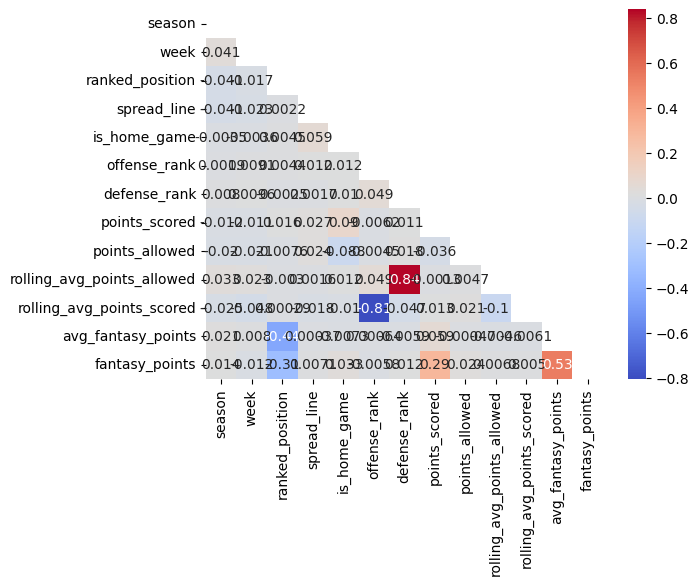

In [23]:
#Analyze Multicolinearity
corr = df_pred.select_dtypes('number').corr()
print(corr)
sns.heatmap(corr, annot=True, mask=np.triu(corr), cmap='coolwarm')
plt.show()
#print(df_pred[['offense_rank','points_scored', 'avg_fantasy_points']].corr())
#df_pred['offense_points_interaction'] = df_pred['offense_rank'] * df_pred['points_scored']
#print(df_pred[['offense_rank', 'points_scored', 'offense_points_interaction','fantasy_points']].corr())



In [24]:

#create interaction terms for moderatly correlated features
df_pred['interaction_term'] = df_pred['ranked_position'] * df_pred['avg_fantasy_points']

#Final feature seleciton
df_pred = df_pred[['season','week','team','position','ranked_position','opponent','spread_line','roof', 'is_home_game','points_allowed','points_scored','interaction_term', 'avg_fantasy_points','fantasy_points']]

/var/folders/f8/sj2vh6pn2550v8b3lybk3zbw0000gn/T/ipykernel_38292/1444836297.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['interaction_term'] = df_pred['ranked_position'] * df_pred['avg_fantasy_points']


In [25]:
# coach is excluded. To include add 'coach' 
df_pred = pd.get_dummies(df_pred, columns=['team', 'opponent', 'roof','position'], drop_first=True)

#check again for collinearity
print(df_pred[['position_QB','position_WR','position_HB','position_TE','position_RB' ,'avg_fantasy_points']].corr())

#create interaction terms for positions
df_pred['qb_interaction'] = df_pred['position_QB'] * df_pred['avg_fantasy_points'] #interactions term because of moderate collinearity


                    position_QB  position_WR  position_HB  position_TE  \
position_QB            1.000000    -0.327323    -0.008377    -0.183513   
position_WR           -0.327323     1.000000    -0.016055    -0.351691   
position_HB           -0.008377    -0.016055     1.000000    -0.009001   
position_TE           -0.183513    -0.351691    -0.009001     1.000000   
position_RB           -0.270058    -0.517549    -0.013246    -0.290163   
avg_fantasy_points     0.583836    -0.196110    -0.021961    -0.248996   

                    position_RB  avg_fantasy_points  
position_QB           -0.270058            0.583836  
position_WR           -0.517549           -0.196110  
position_HB           -0.013246           -0.021961  
position_TE           -0.290163           -0.248996  
position_RB            1.000000           -0.029375  
avg_fantasy_points    -0.029375            1.000000  


In [ ]:
df_pred

,season,week,ranked_position,spread_line,is_home_game,points_allowed,points_scored,interaction_term,avg_fantasy_points,fantasy_points,...,coach_Shane Steichen,coach_Steve Spagnuolo,coach_Steve Wilks,coach_Todd Bowles,coach_Tom Coughlin,coach_Urban Meyer,coach_Vance Joseph,coach_Vic Fangio,coach_Zac Taylor,qb_interaction
607,2015,2,1,-2.0,0,23.0,48.0,25.680000,25.680000,21.200001,...,0,0,0,0,0,0,0,0,0,25.680000
881,2015,3,1,7.0,1,7.0,47.0,23.440001,23.440001,18.540001,...,0,0,0,0,0,0,0,0,0,23.440001
628,2015,5,1,-4.5,0,17.0,42.0,21.806667,21.806667,18.340000,...,0,0,0,0,0,0,0,0,0,21.806667
652,2015,6,1,-5.5,0,25.0,13.0,20.940001,20.940001,16.740000,...,0,0,0,0,0,0,0,0,0,20.940001
414,2015,7,1,10.0,1,18.0,26.0,20.100000,20.100000,19.200001,...,0,0,0,0,0,0,0,0,0,20.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2015,12,4,-1.0,1,14.0,20.0,11.680000,2.920000,0.000000,...,0,0,0,0,0,0,0,0,0,0.000000
3355,2015,14,4,4.0,0,21.0,24.0,8.800000,2.200000,2.700000,...,0,0,0,0,0,0,0,0,0,0.000000
5312,2016,1,4,-2.5,1,38.0,16.0,9.520000,2.380000,5.800000,...,0,0,0,0,0,0,0,0,0,0.000000
4980,2016,2,4,3.5,1,27.0,23.0,13.680000,3.420000,9.900000,...,0,0,0,0,0,0,0,0,0,0.000000


Aktueller Stand: DF ist vollständig gemerged enthält das korrekte Positionsranking für jedes Team und spiel

Next steps:
- Mache weiter bei den Seasons 2016-2024 und vervollständige den Datensatz
- DF in Positionen aufteilen
- Modelle laufen

In [ ]:
#Linear regression
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Mean Squared Error: 34.63
Root Mean Squared Error: 5.88
R-squared: 0.40
                   Feature  Coefficient  Absolute Coefficient
75             position_QB     6.073636              6.073636
76             position_RB     3.692297              3.692297
78             position_WR     3.513206              3.513206
151    coach_Romeo Crennel     3.003692              3.003692
106       coach_Giff Smith    -2.789726              2.789726
..                     ...          ...                   ...
126  coach_Kevin Stefanski    -0.011729              0.011729
61             opponent_NO     0.006688              0.006688
43            opponent_CAR    -0.006306              0.006306
3              spread_line    -0.000510              0.000510
80      coach_Anthony Lynn    -0.000039              0.000039

[166 rows x 3 columns]


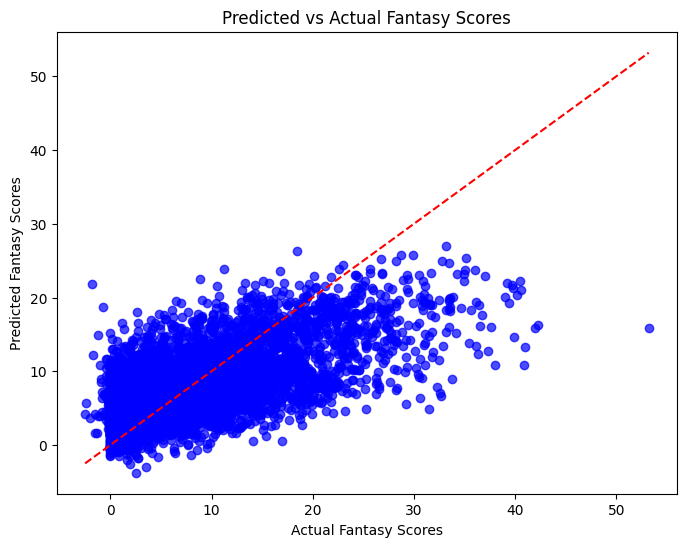

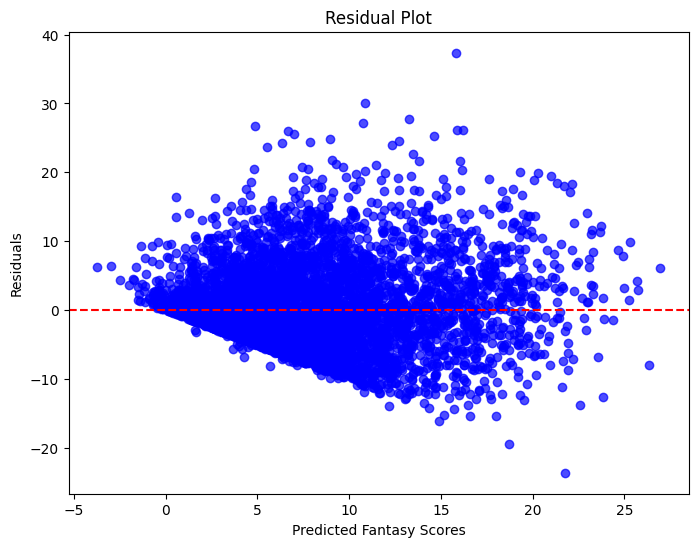

In [ ]:
# Define feature columns (X) and target (y)
X = df_pred.drop(columns=['fantasy_points'])
y = df_pred['fantasy_points']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Linear Regression for simplicity)
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients and feature names
coefficients = model.coef_
feature_names = X.columns

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model
#MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

#RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

#R2
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

#coefficients
# Create a dataframe to display the features and their corresponding coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients (to see the most impactful features)
coeff_df['Absolute Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the results
print(coeff_df)

#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('Actual Fantasy Scores')
plt.ylabel('Predicted Fantasy Scores')
plt.title('Predicted vs Actual Fantasy Scores')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Line for zero residuals
plt.xlabel('Predicted Fantasy Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Random Forest MSE: 34.03
Random Forest R²: 0.41


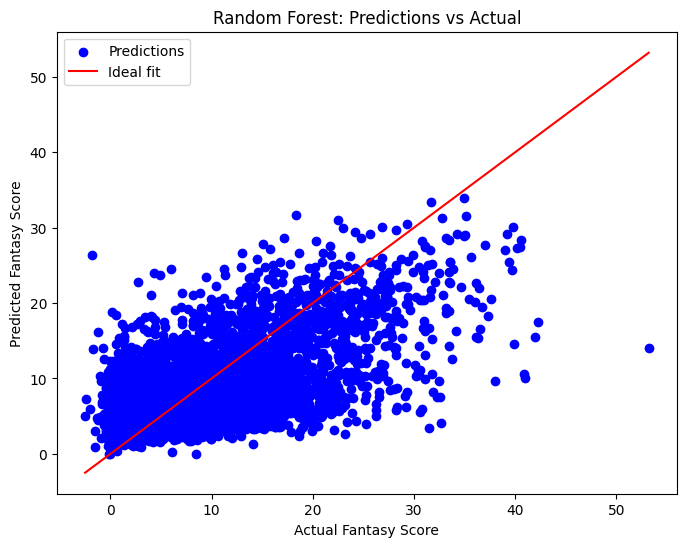

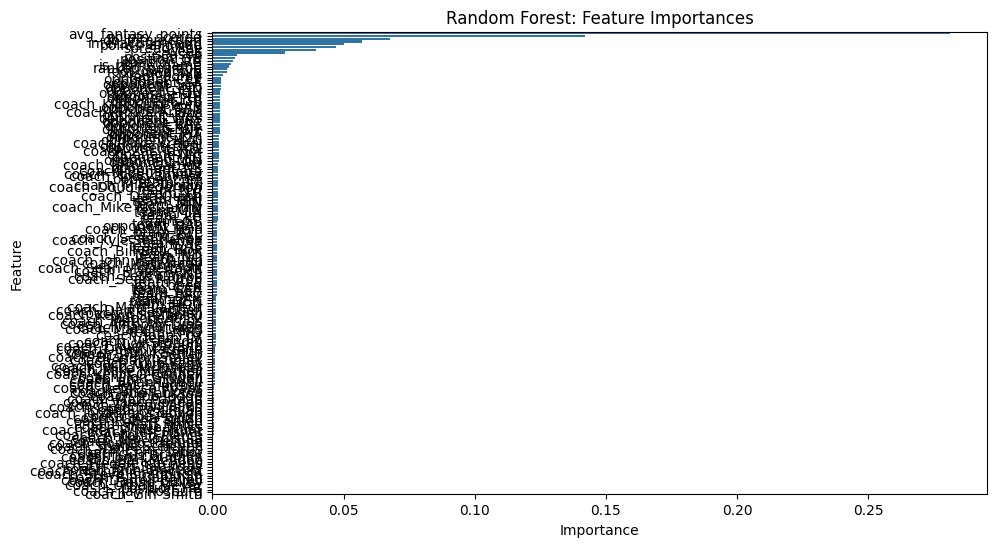

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.2f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal fit')
plt.title('Random Forest: Predictions vs Actual')
plt.xlabel('Actual Fantasy Score')
plt.ylabel('Predicted Fantasy Score')
plt.legend()
plt.show()

# Visualize feature importances
features = X_train.columns
importances = rf_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest: Feature Importances')
plt.show()

Mean Squared Error (MSE): 34.41
Mean Absolute Error (MAE): 4.42
R-squared (R2): 0.40


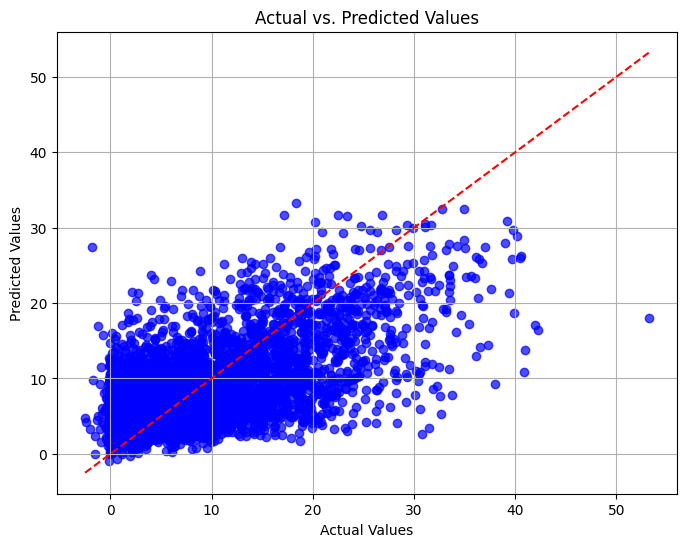

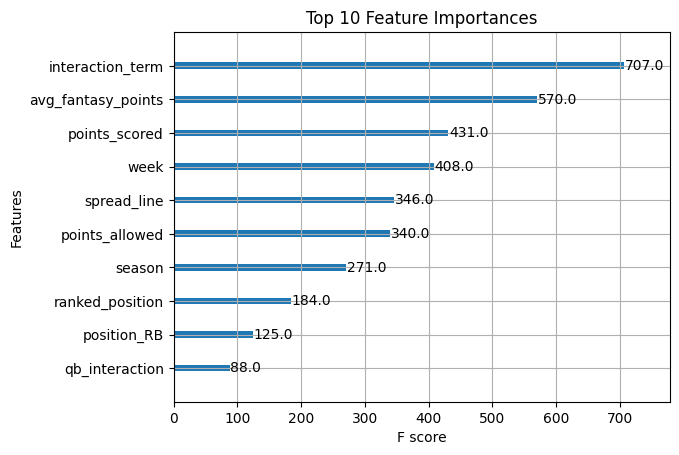

In [ ]:
#XG Boost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Initialize and train the model
gbm_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
gbm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_gbm = gbm_model.predict(X_test)



# Calculate metrics
mse = mean_squared_error(y_test, y_pred_gbm)
mae = mean_absolute_error(y_test, y_pred_gbm)
r2 = r2_score(y_test, y_pred_gbm)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gbm, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

# Plot feature importance
xgb.plot_importance(gbm_model, importance_type='weight', max_num_features=10, title="Top 10 Feature Importances")
plt.show()